In [1]:
!pip install -U jax[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib[cuda112] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install imbalanced-learn
!pip install -U git+https://github.com/Habush/Sklearn-genetic-opt.git
!pip install lark==1.1.2
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt-get -y install swig
!pip install smac

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.21-py3-none-any.whl size=1263550 sha256=8cddaa9e6c4bac8718e26e3d2558679ce2560846df4b1ca15e2d22640044253f
  Stored in directory: /root/.cache/pip/wheels/cd/fe/13/b51a21b340580b56f5378c5e68d14d19e74e956d575397c41f
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 MB 11.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
  

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

In [2]:
if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import jax
import haiku as hk
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import blackjax
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nn_util import *
from gibbs_sampler import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
jax.default_backend()

'gpu'

### Load Dataset

In [66]:
seeds, data_dfs, net_dfs, feat_ls = load_bmm_files("./bmm_data_thr_5_F_8_f500")
seeds

[422,
 261,
 968,
 282,
 739,
 573,
 220,
 413,
 745,
 775,
 482,
 442,
 210,
 423,
 760,
 57,
 769,
 920,
 226,
 196]

In [67]:
%autoreload
seed_idx = 0
seed, net, data = prepare_data(seeds, seed_idx, data_dfs, net_dfs, test_size=0.3)
print(seed)
X_train, X_test, y_train, y_test = data

p = X_train.shape[1]
rng_key = jax.random.PRNGKey(seed)

422


In [68]:
x_train_cv, x_val, y_train_cv, y_val = train_test_split(X_train, y_train, shuffle=True, random_state=seed, stratify=y_train, test_size=0.3)
x_train_cv, x_val, y_train_cv, y_val = jax.device_put(x_train_cv), jax.device_put(x_val), \
                                        jax.device_put(y_train_cv), jax.device_put(y_val)

In [69]:
train_data = Batch(x_train_cv, y_train_cv)
val_data = Batch(x_val, y_val)
test_data = Batch(X_test, y_test)

In [70]:
test_data.x.shape

(120, 500)

### Baseline Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(max_iter=10000)
cv_score = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))
clf.fit(X_train, y_train)
test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"cv score: {cv_score}, test_score: {test_score}")

cv score: 0.6360873694207028, test_score: 0.6823793490460157


In [11]:
key_samples, key_init, key_warmup, key = jax.random.split(rng_key, 4)

In [12]:
def make_batch(idx, x, y):
    return Batch(x[idx], y[idx])

def disc_log_prob(model, log_prior_fn, log_likelihood_fn,
             state, batch):

    log_prior = log_prior_fn(state.discrete_position)
    log_ll = log_likelihood_fn(model, state.contin_position, batch, state.discrete_position)

    return log_prior + log_ll

def contin_log_prob(model, log_prior_fn, log_likelihood_fn,
                  state, batch):

    log_prior = log_prior_fn(state.contin_position)
    log_ll = log_likelihood_fn(model, state.contin_position, batch, state.discrete_position)

    return log_prior + log_ll


In [13]:
train_data.x.shape

(192, 100)

In [14]:
def get_mixed_model_auc(model, params, data, gamma):
    logits = model.apply(params, data.x, gamma).ravel()
    pred_probs = jax.nn.sigmoid(logits)
    return roc_auc_score(data.y, pred_probs)

def get_model_auc(model, params, data):
    logits = model.apply(params, data.x).ravel()
    pred_probs = jax.nn.sigmoid(logits)
    return roc_auc_score(data.y, pred_probs)


def get_mixed_model_pred(model, params, data, gamma):
    logits = model.apply(params, data.x, gamma).ravel()
    pred_probs = jax.nn.sigmoid(logits)
    return pred_probs

def get_model_pred(model, params, data):
    logits = model.apply(params, data.x).ravel()
    pred_probs = jax.nn.sigmoid(logits)
    return pred_probs



def make_cyclical_cosine_lr_schedule_with_const_burnin(init_lr, burnin_steps,
                                                       cycle_length):

    def schedule(step):
        t = jnp.maximum(step - burnin_steps - 1, 0.)
        t = (t % cycle_length) / cycle_length
        return 0.5 * init_lr * (1 + jnp.cos(t * jnp.pi))

    return schedule

In [28]:
%autoreload
from gibbs_sampler import *
from nn_util import  *
from nn_models import make_mixed_net_fn
import optax

# optax.exponential_decay()

sigma = 1.
eta, mu = 0.3, 0.3

num_samples = 3000
num_warmup = 1000
num_eval = 100
num_chains = 3
n = (num_samples-num_warmup)

alpha = 0.99

data_size = x_train_cv.shape[0]
batch_size = 50

mixed_net_fn = make_mixed_net_fn(layer_dims=[70], output_dim=1, activation_fns=["tanh"])

mixed_model = hk.without_apply_rng(hk.transform(mixed_net_fn))

disc_logprior_fn = generate_disc_logprior_fn(net, mu, eta)
contin_logprior_fn = generate_contin_logprior_fn(sigma)

disc_grad_est_fn = generate_discrete_grad_estimator(mixed_model, disc_logprior_fn, data_size)
contin_grad_est_fn = geneate_mixed_contin_grad_estimator(mixed_model , contin_logprior_fn, data_size)



In [61]:
from tqdm import tqdm

init_disc_lr, init_contin_lr = 0.2, 1e-5
disc_step_fn = lambda _: init_disc_lr
contin_step_fn = lambda _ : init_contin_lr

mixed_const_lr_kernel = jax.jit(get_mixed_sgld_kernel(disc_grad_est_fn, contin_grad_est_fn, disc_step_fn, contin_step_fn))

mixed_const_lr_states_02 = []
mixed_const_lr_disc_logprobs_02 = np.zeros((num_chains, num_samples))
mixed_const_lr_contin_logprobs_02 = np.zeros((num_chains, num_samples))
mixed_const_lr_log_lls_02 = np.zeros((num_chains, num_samples))
mixed_const_lr_val_preds_02 = np.zeros((num_chains, n, val_data.x.shape[0]))
mixed_const_lr_test_preds_02 = np.zeros((num_chains, n, test_data.x.shape[0]))
mixed_const_lr_val_prob_preds_02 = np.zeros((num_chains,val_data.x.shape[0]))
mixed_const_lr_test_prob_preds_02 = np.zeros((num_chains,test_data.x.shape[0]))


chain_keys = jax.random.split(rng_key, num_chains)

for c in range(num_chains):
    subkey = chain_keys[c]
    init_gamma = tfd.Bernoulli(probs=0.5*jnp.ones(p)).sample(seed=subkey)*1.
    init_idx = jax.random.choice(subkey, jnp.arange(data_size), shape=(batch_size, ), replace=False)
    init_batch = Batch(train_data.x[init_idx], train_data.y[init_idx])
    init_params = mixed_model.init(subkey, init_batch.x, init_gamma)
    mixed_state = init_mixed_sgld(init_gamma, init_params, alpha)
    keys = jax.random.split(subkey, num_samples)
    chain_states = []
    j = 0
    for i in tqdm(range(num_samples)):
        key = keys[i]
        idx = jax.random.choice(key, jnp.arange(data_size), shape=(batch_size, ), replace=False)
        batch = Batch(train_data.x[idx], train_data.y[idx])
        mixed_state = mixed_const_lr_kernel(key, mixed_state, batch)
        val_ensmeble_pred_probs = 0.0
        test_ensmeble_pred_probs = 0.0
        if i > num_warmup: # sampling stage
            chain_states.append(mixed_state)
            val_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, val_data.x, mixed_state.discrete_position)
            test_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, test_data.x, mixed_state.discrete_position)
            # print(f"Train AUC: {train_auc: .3f}, Val AUC: {val_auc: .3f},  Test AUC: {test_auc: .3f}")
            val_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(val_ensmeble_pred_probs, j, val_pred_prob)
            test_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(test_ensmeble_pred_probs, j, test_pred_prob)
            mixed_const_lr_val_preds_02[c, j] = (val_pred_prob > 0.5).astype(jnp.float32)
            mixed_const_lr_test_preds_02[c, j] = (test_pred_prob > 0.5).astype(jnp.float32)
            j += 1


        mixed_const_lr_val_prob_preds_02[c] = val_ensmeble_pred_probs
        mixed_const_lr_test_preds_02[c] = test_ensmeble_pred_probs
        disc_logprior = disc_logprior_fn(mixed_state.discrete_position)
        contin_logprior = contin_logprior_fn(mixed_state.contin_position)
        log_ll = mixed_loglikelihood_fn(mixed_model, mixed_state.contin_position, batch, mixed_state.discrete_position)
        mixed_const_lr_disc_logprobs_02[c, i] = disc_logprior
        mixed_const_lr_contin_logprobs_02[c, i] = contin_logprior
        mixed_const_lr_log_lls_02[c, i] = log_ll

    mixed_const_lr_states_02.append(chain_states)
    print(f"Done for chain - {c+1}")

  0%|          | 0/2000 [00:00<?, ?it/s]/notebooks/gibbs_sampler.py:62: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  n_params = sum([p.size for p in jax.tree_leaves(params)])
100%|██████████| 2000/2000 [00:31<00:00, 63.03it/s]


Done for chain - 1


100%|██████████| 2000/2000 [00:29<00:00, 67.64it/s]


Done for chain - 2


100%|██████████| 2000/2000 [00:29<00:00, 68.11it/s]

Done for chain - 3


In [16]:
%autoreload
from gibbs_sampler import *
from tqdm import tqdm

init_disc_lr, init_contin_lr = 1e-5, 1e-5
disc_step_fn = lambda _: (init_disc_lr, _)
contin_step_fn = lambda _ : (init_contin_lr, _)

mixed_const_lr_kernel = jax.jit(get_mixed_sgld_kernel(disc_grad_est_fn, contin_grad_est_fn, disc_step_fn, contin_step_fn))

mixed_const_lr_states_1_e5 = []
mixed_const_lr_disc_logprobs_1_e5 = np.zeros((num_chains, num_samples))
mixed_const_lr_contin_logprobs_1_e5 = np.zeros((num_chains, num_samples))
mixed_const_lr_log_lls_1_e5 = np.zeros((num_chains, num_samples))
mixed_const_lr_val_preds_1_e5 = np.zeros((num_chains, n, val_data.x.shape[0]))
mixed_const_lr_test_preds_1_e5 = np.zeros((num_chains, n, test_data.x.shape[0]))
mixed_const_lr_val_prob_preds_1_e5 = np.zeros((num_chains,val_data.x.shape[0]))
mixed_const_lr_test_prob_preds_1_e5 = np.zeros((num_chains,test_data.x.shape[0]))


chain_keys = jax.random.split(rng_key, num_chains)

for c in range(num_chains):
    subkey = chain_keys[c]
    init_gamma = tfd.Bernoulli(probs=0.5*jnp.ones(p)).sample(seed=subkey)*1.
    init_idx = jax.random.choice(subkey, jnp.arange(data_size), shape=(batch_size, ), replace=False)
    init_batch = Batch(train_data.x[init_idx], train_data.y[init_idx])
    init_params = mixed_model.init(subkey, init_batch.x, init_gamma)
    mixed_state = init_mixed_sgld(init_gamma, init_params, alpha)
    keys = jax.random.split(subkey, num_samples)
    chain_states = []
    j = 0
    for i in tqdm(range(num_samples)):
        key = keys[i]
        idx = jax.random.choice(key, jnp.arange(data_size), shape=(batch_size, ), replace=False)
        batch = Batch(train_data.x[idx], train_data.y[idx])
        mixed_state = mixed_const_lr_kernel(key, mixed_state, batch)
        val_ensmeble_pred_probs = 0.0
        test_ensmeble_pred_probs = 0.0
        if i > num_warmup: # sampling stage
            chain_states.append(mixed_state)
            val_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, val_data.x, mixed_state.discrete_position)
            test_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, test_data.x, mixed_state.discrete_position)
            # print(f"Train AUC: {train_auc: .3f}, Val AUC: {val_auc: .3f},  Test AUC: {test_auc: .3f}")
            val_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(val_ensmeble_pred_probs, j, val_pred_prob)
            test_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(test_ensmeble_pred_probs, j, test_pred_prob)
            mixed_const_lr_val_preds_1_e5[c, j] = (val_pred_prob > 0.5).astype(jnp.float32)
            mixed_const_lr_test_preds_1_e5[c, j] = (test_pred_prob > 0.5).astype(jnp.float32)
            j += 1


        mixed_const_lr_val_prob_preds_1_e5[c] = val_ensmeble_pred_probs
        mixed_const_lr_test_preds_1_e5[c] = test_ensmeble_pred_probs
        disc_logprior = disc_logprior_fn(mixed_state.discrete_position)
        contin_logprior = contin_logprior_fn(mixed_state.contin_position)
        log_ll = mixed_loglikelihood_fn(mixed_model, mixed_state.contin_position, batch, mixed_state.discrete_position)
        mixed_const_lr_disc_logprobs_1_e5[c, i] = disc_logprior
        mixed_const_lr_contin_logprobs_1_e5[c, i] = contin_logprior
        mixed_const_lr_log_lls_1_e5[c, i] = log_ll

    mixed_const_lr_states_1_e5.append(chain_states)
    print(f"Done for chain - {c+1}")

100%|██████████| 2000/2000 [02:53<00:00, 11.50it/s]


Done for chain - 1


100%|██████████| 2000/2000 [00:33<00:00, 60.54it/s]


Done for chain - 2


100%|██████████| 2000/2000 [00:33<00:00, 60.48it/s]

Done for chain - 3


In [67]:
%autoreload
from gibbs_sampler import *
from tqdm import tqdm

init_disc_lr, init_contin_lr = 5e-5, 1e-5

cycle_len = 100

beta = 0.4

disc_cyc_step_fn_10 = make_cyclical_cosine_lr_schedule_with_const_burnin(init_disc_lr, num_warmup, cycle_len)
contin_cyc_step_fn_10 = make_cyclical_cosine_lr_schedule_with_const_burnin(init_contin_lr, num_warmup, cycle_len)

mixed_cyc_lr_kernel_10 = jax.jit(get_mixed_sgld_kernel(disc_grad_est_fn, contin_grad_est_fn, disc_cyc_step_fn_10, contin_cyc_step_fn_10))

k = ((num_samples - num_warmup + 1) // cycle_len)
u = (cycle_len - int(cycle_len * beta)) - 1
cs = k * u
mixed_cyc_lr_states = []
mixed_cyc_lr_disc_logprobs_10 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_contin_logprobs_10 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_log_lls_10 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_val_preds_10 = np.zeros((num_chains, cs, val_data.x.shape[0]))
mixed_cyc_lr_test_preds_10 = np.zeros((num_chains, cs, test_data.x.shape[0]))
mixed_cyc_lr_val_prob_preds_10 = np.zeros((num_chains, cs, val_data.x.shape[0]))
mixed_cyc_lr_test_prob_preds_10 = np.zeros((num_chains, cs, test_data.x.shape[0]))


chain_keys = jax.random.split(rng_key, num_chains)

for c in range(num_chains):
    subkey = chain_keys[c]
    init_gamma = tfd.Bernoulli(probs=0.5*jnp.ones(p)).sample(seed=subkey)*1.
    init_idx = jax.random.choice(subkey, jnp.arange(data_size), shape=(batch_size, ), replace=False)
    init_batch = Batch(train_data.x[init_idx], train_data.y[init_idx])
    init_params = mixed_model.init(subkey, init_batch.x, init_gamma)
    mixed_state = init_mixed_sgld(init_gamma, init_params, alpha)
    keys = jax.random.split(subkey, num_samples)
    chain_states = []
    j = 0
    for i in tqdm(range(num_samples)):
        key = keys[i]
        idx = jax.random.choice(key, jnp.arange(data_size), shape=(batch_size, ), replace=False)
        batch = Batch(train_data.x[idx], train_data.y[idx])
        mixed_state = mixed_cyc_lr_kernel_10(key, mixed_state, batch)
        val_ensmeble_pred_probs = 0.0
        test_ensmeble_pred_probs = 0.0
        step, t = disc_cyc_step_fn_10(i)
        if i > num_warmup and t > beta: # sampling stage
            chain_states.append(mixed_state)
            val_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, val_data.x, mixed_state.discrete_position)
            test_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, test_data.x, mixed_state.discrete_position)
            # print(f"Train AUC: {train_auc: .3f}, Val AUC: {val_auc: .3f},  Test AUC: {test_auc: .3f}")
            val_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(val_ensmeble_pred_probs, j, val_pred_prob)
            test_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(test_ensmeble_pred_probs, j, test_pred_prob)
            mixed_cyc_lr_val_preds_10[c, j] = (val_pred_prob > 0.5).astype(jnp.float32)
            mixed_cyc_lr_test_preds_10[c, j] = (test_pred_prob > 0.5).astype(jnp.float32)
            j += 1


        mixed_cyc_lr_val_prob_preds_10[c] = val_ensmeble_pred_probs
        mixed_cyc_lr_test_preds_10[c] = test_ensmeble_pred_probs
        disc_logprior = disc_logprior_fn(mixed_state.discrete_position)
        contin_logprior = contin_logprior_fn(mixed_state.contin_position)
        log_ll = mixed_loglikelihood_fn(mixed_model, mixed_state.contin_position, batch, mixed_state.discrete_position)
        mixed_cyc_lr_disc_logprobs_10[c, i] = disc_logprior
        mixed_cyc_lr_contin_logprobs_10[c, i] = contin_logprior
        mixed_cyc_lr_log_lls_10[c, i] = log_ll

    mixed_cyc_lr_states.append(chain_states)
    print(f"Done for chain - {c+1}")

100%|██████████| 3000/3000 [00:54<00:00, 54.76it/s]


Done for chain - 1


100%|██████████| 3000/3000 [00:51<00:00, 57.75it/s]


Done for chain - 2


100%|██████████| 3000/3000 [00:52<00:00, 56.86it/s]

Done for chain - 3


In [81]:
from tqdm import tqdm

cycle_len = 100
init_disc_lr, init_contin_lr = 5e-5, 1e-5
disc_cyc_step_fn_100 = make_cyclical_cosine_lr_schedule_with_const_burnin(init_disc_lr, num_warmup, cycle_len)
contin_cyc_step_fn_100 = make_cyclical_cosine_lr_schedule_with_const_burnin(init_contin_lr, num_warmup, cycle_len)

mixed_cyc_lr_kernel_100 = jax.jit(get_mixed_sgld_kernel(disc_grad_est_fn, contin_grad_est_fn, disc_cyc_step_fn_100, contin_cyc_step_fn_100))

beta = 0.4
k = ((num_samples - num_warmup + 1) // cycle_len)
u = (cycle_len - int(cycle_len * beta))
cs = k * u

mixed_cyc_lr_states_100 = []
mixed_cyc_lr_disc_logprobs_100 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_contin_logprobs_100 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_log_lls_100 = np.zeros((num_chains, num_samples))
mixed_cyc_lr_val_preds_100 = np.zeros((num_chains, cs, val_data.x.shape[0]))
mixed_cyc_lr_test_preds_100 = np.zeros((num_chains, cs, test_data.x.shape[0]))
mixed_cyc_lr_val_prob_preds_100 = np.zeros((num_chains,val_data.x.shape[0]))
mixed_cyc_lr_test_prob_preds_100 = np.zeros((num_chains,test_data.x.shape[0]))


chain_keys = jax.random.split(rng_key, num_chains)

for c in range(num_chains):
    subkey = chain_keys[c]
    init_gamma = tfd.Bernoulli(probs=0.5*jnp.ones(p)).sample(seed=subkey)*1.
    init_idx = jax.random.choice(subkey, jnp.arange(data_size), shape=(batch_size, ), replace=False)
    init_batch = Batch(train_data.x[init_idx], train_data.y[init_idx])
    init_params = mixed_model.init(subkey, init_batch.x, init_gamma)
    mixed_state = init_mixed_sgld(init_gamma, init_params, alpha)
    keys = jax.random.split(subkey, num_samples)
    chain_states = []
    j = 0
    for i in tqdm(range(num_samples)):
        key = keys[i]
        idx = jax.random.choice(key, jnp.arange(data_size), shape=(batch_size, ), replace=False)
        batch = Batch(train_data.x[idx], train_data.y[idx])
        mixed_state = mixed_cyc_lr_kernel_100(key, mixed_state, batch)
        val_ensmeble_pred_probs = 0.0
        test_ensmeble_pred_probs = 0.0
        step, t = disc_cyc_step_fn_10(i)
        if i > num_warmup and t > beta: # sampling stage
            chain_states.append(mixed_state)
            val_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, val_data.x, mixed_state.discrete_position)
            test_pred_prob = get_mixed_model_pred(mixed_model, mixed_state.contin_position, test_data.x, mixed_state.discrete_position)
            # print(f"Train AUC: {train_auc: .3f}, Val AUC: {val_auc: .3f},  Test AUC: {test_auc: .3f}")
            val_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(val_ensmeble_pred_probs, j, val_pred_prob)
            test_ensmeble_pred_probs = compute_updated_ensemble_predictions_classification(test_ensmeble_pred_probs, j, test_pred_prob)
            mixed_cyc_lr_val_preds_100[c, j] = (val_pred_prob > 0.5).astype(jnp.float32)
            mixed_cyc_lr_test_preds_100[c, j] = (test_pred_prob > 0.5).astype(jnp.float32)
            j += 1


        mixed_cyc_lr_val_prob_preds_100[c] = val_ensmeble_pred_probs
        mixed_cyc_lr_test_preds_100[c] = test_ensmeble_pred_probs
        disc_logprior = disc_logprior_fn(mixed_state.discrete_position)
        contin_logprior = contin_logprior_fn(mixed_state.contin_position)
        log_ll = mixed_loglikelihood_fn(mixed_model, mixed_state.contin_position, batch, mixed_state.discrete_position)
        mixed_cyc_lr_disc_logprobs_100[c, i] = disc_logprior
        mixed_cyc_lr_contin_logprobs_100[c, i] = contin_logprior
        mixed_cyc_lr_log_lls_100[c, i] = log_ll

    mixed_cyc_lr_states_100.append(chain_states)
    print(f"Done for chain - {c+1}")

100%|██████████| 3000/3000 [00:56<00:00, 52.73it/s]


Done for chain - 1


100%|██████████| 3000/3000 [00:53<00:00, 56.52it/s]


Done for chain - 2


100%|██████████| 3000/3000 [00:53<00:00, 56.16it/s]

Done for chain - 3


In [71]:
def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = tfp.mcmc.effective_sample_size(c)
    cv = cv.at[jnp.isnan(cv)].set(1.)
    return cv

In [83]:
q = len(mixed_cyc_lr_states_100[0])
print(q)
gamma_samples = np.zeros((num_chains, q, p))

for c in range(num_chains):
    for i in range(q):
        gamma_samples[c, i] = mixed_cyc_lr_states_100[c][i].discrete_position

1179


In [84]:
jnp.mean(jnp.vstack([get_ess(gamma_samples[0], 0), get_ess(gamma_samples[1], 0), get_ess(gamma_samples[2], 0)]))

/usr/local/lib/python3.9/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


DeviceArray(70.61935, dtype=float32)

In [78]:
get_ess(gamma_samples[2], 0),

(DeviceArray([ 10.23108  ,  20.378563 ,  53.135803 ,   1.       ,
                1.       ,  26.540377 , 139.15045  ,  74.048515 ,
               11.213839 ,  21.463682 ,   1.       ,  22.548677 ,
               13.195227 , 122.79065  ,  53.74645  ,  31.346111 ,
               14.896518 ,   1.       , 150.59662  ,   9.573099 ,
              140.11035  , 106.72635  ,  19.556196 ,  46.17945  ,
               38.953274 , 135.60559  ,   1.       ,  22.96246  ,
               16.478958 ,  19.914421 ,  51.02559  ,  13.5901575,
               19.618786 ,  22.506662 ,  11.139032 ,  25.871943 ,
              848.44336  ,  46.370796 ,  69.50765  ,   1.       ,
               19.822844 ,  44.450073 ,  56.508068 , 108.26121  ,
               73.20105  , 606.1537   ,  69.716835 ,   1.       ,
              451.4219   , 149.06554  ,  76.92306  ,  91.15704  ,
               25.886063 , 155.19498  ,  14.126829 ,  28.30279  ,
                1.       ,  40.770336 , 353.28186  ,  25.202497 ,
          

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 12))
fig.suptitle("SG-MCMC - Constant Lr - Step size - 0.2")
for i in range(num_chains):
    ax1[0].plot(mixed_const_lr_disc_logprobs_02[i], label=f"Chain - {i + 1} gamma log prior")
    ax1[1].plot(mixed_const_lr_contin_logprobs_02[i], label=f"Chain - {i + 1} contin log prior")
    ax2[0].plot(mixed_const_lr_log_lls_02[i], label=f"Chain - {i + 1} log LL")

ax1[0].legend()
ax1[1].legend()
ax2[0].legend()

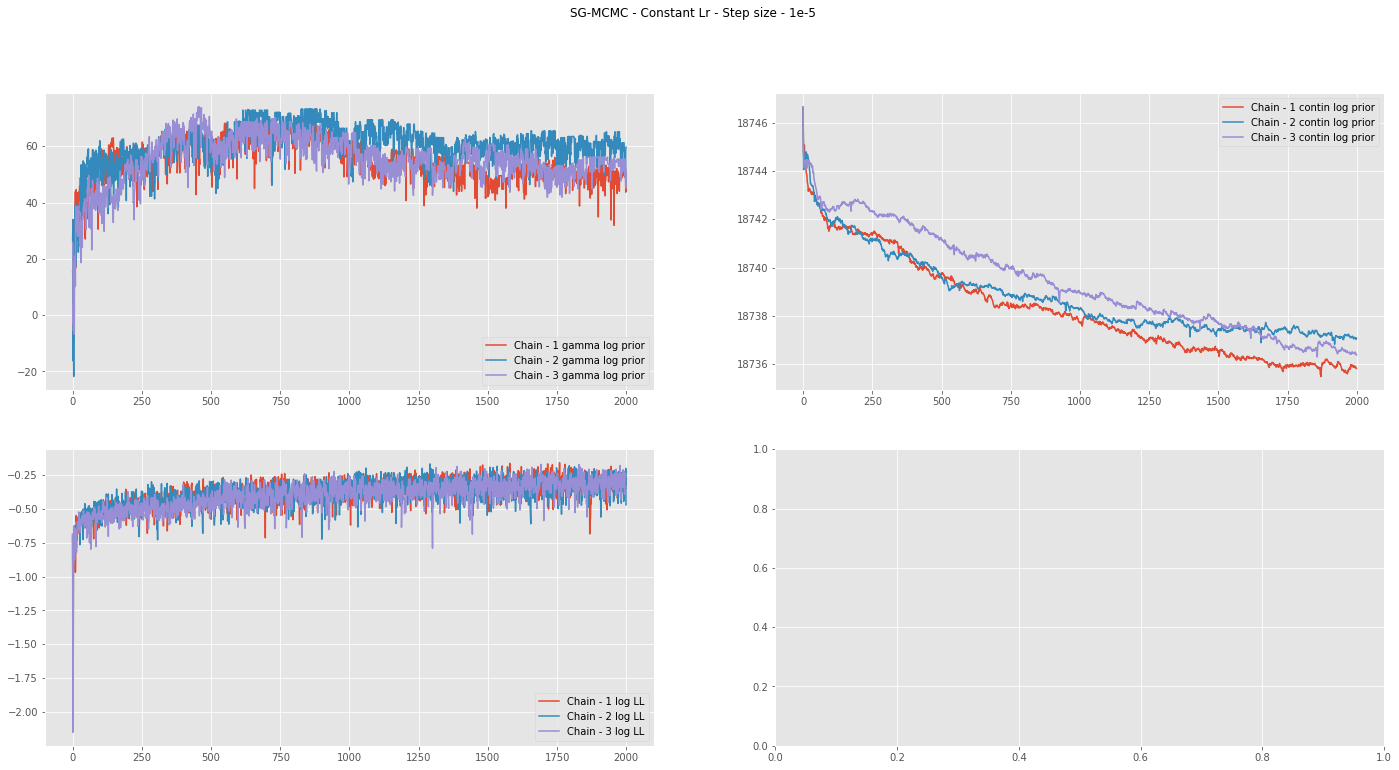

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 12))
fig.suptitle("SG-MCMC - Constant Lr - Step size - 1e-5")
for i in range(num_chains):
    ax1[0].plot(mixed_const_lr_disc_logprobs_1_e5[i], label=f"Chain - {i + 1} gamma log prior")
    ax1[1].plot(mixed_const_lr_contin_logprobs_1_e5[i], label=f"Chain - {i + 1} contin log prior")
    ax2[0].plot(mixed_const_lr_log_lls_1_e5[i], label=f"Chain - {i + 1} log LL")

ax1[0].legend()
ax1[1].legend()
ax2[0].legend()

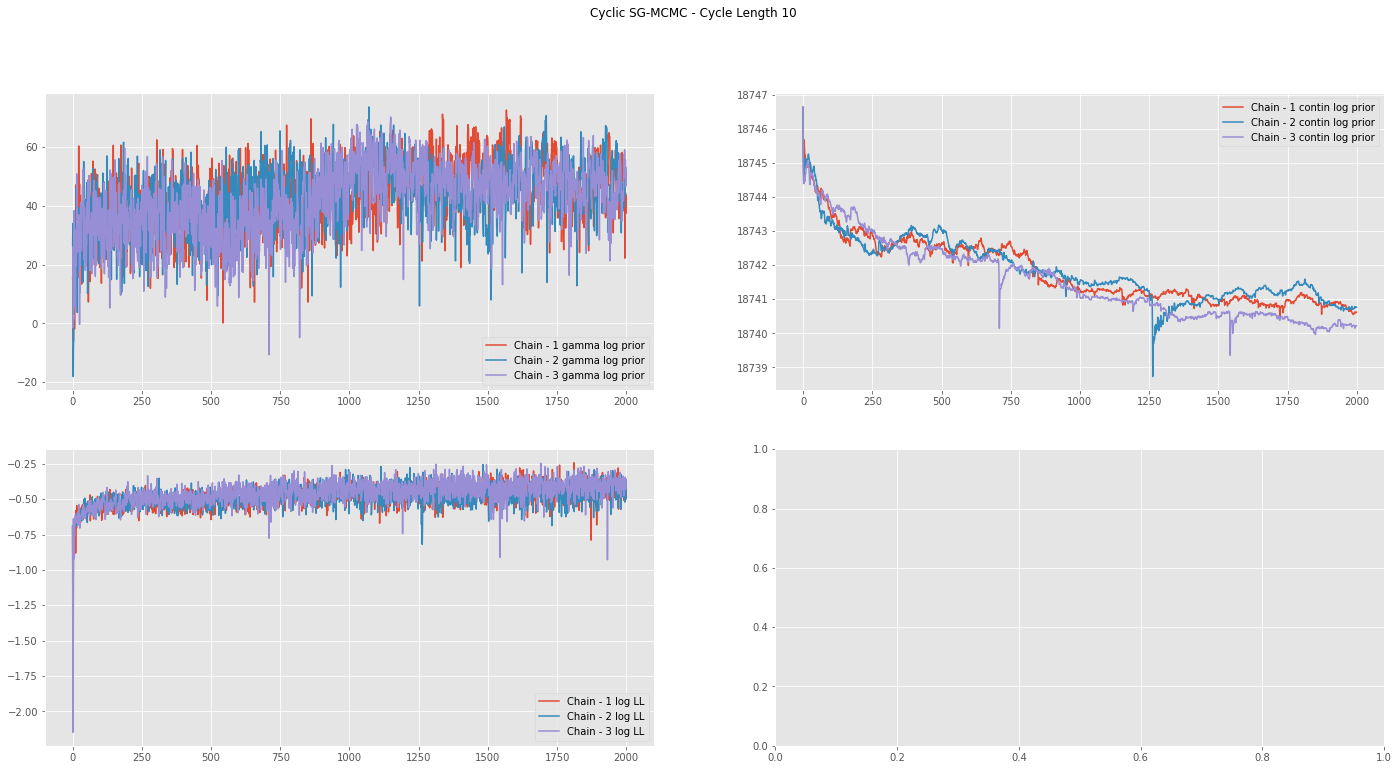

In [115]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 12))
fig.suptitle("Cyclic SG-MCMC - Cycle Length 10")
for i in range(num_chains):
    ax1[0].plot(mixed_cyc_lr_disc_logprobs_10[i], label=f"Chain - {i + 1} gamma log prior")
    ax1[1].plot(mixed_cyc_lr_contin_logprobs_10[i], label=f"Chain - {i + 1} contin log prior")
    ax2[0].plot(mixed_cyc_lr_log_lls_10[i], label=f"Chain - {i + 1} log LL")

ax1[0].legend()
ax1[1].legend()
ax2[0].legend()

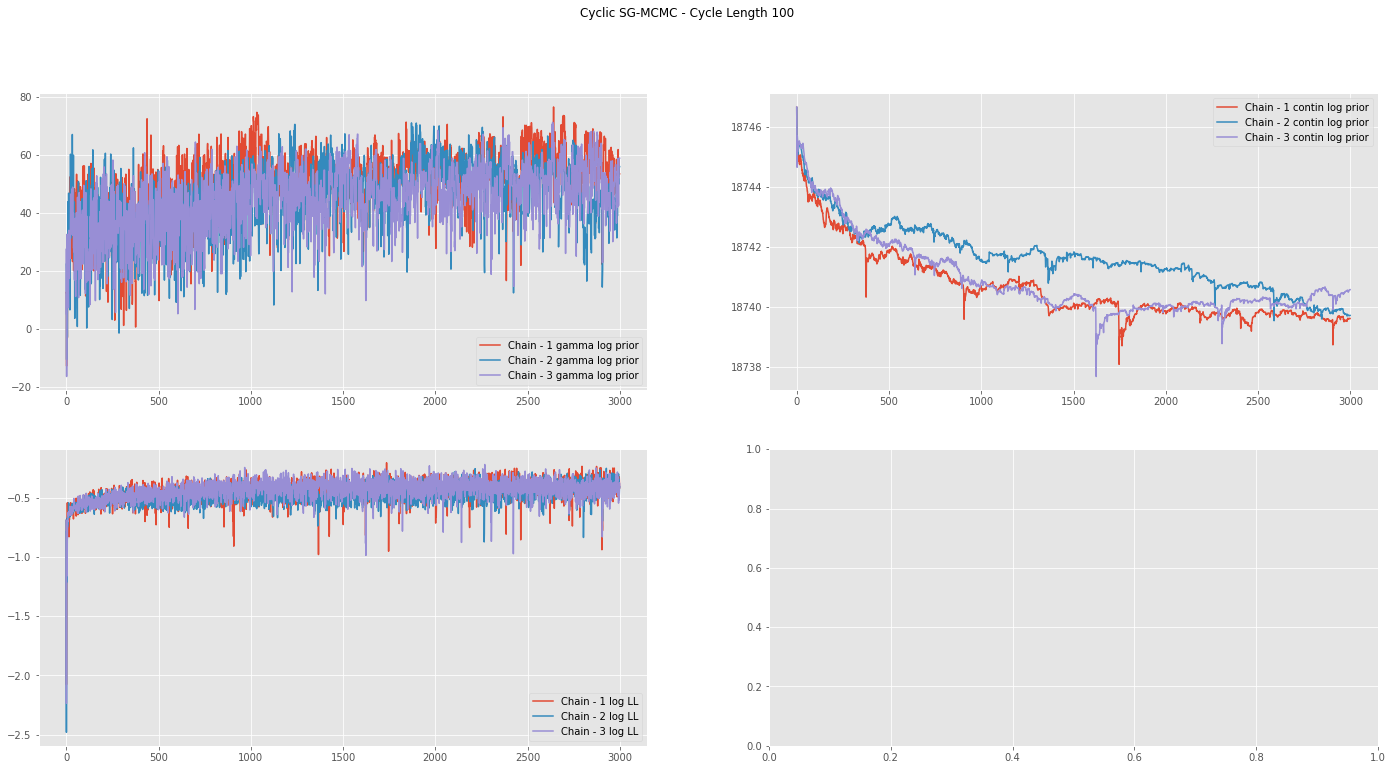

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 12))
fig.suptitle("Cyclic SG-MCMC - Cycle Length 100")
for i in range(num_chains):
    ax1[0].plot(mixed_cyc_lr_disc_logprobs_100[i], label=f"Chain - {i + 1} gamma log prior")
    ax1[1].plot(mixed_cyc_lr_contin_logprobs_100[i], label=f"Chain - {i + 1} contin log prior")
    ax2[0].plot(mixed_cyc_lr_log_lls_100[i], label=f"Chain - {i + 1} log LL")

ax1[0].legend()
ax1[1].legend()
ax2[0].legend()
# ax3.legend()

In [100]:
print(roc_auc_score(val_data.y ,np.mean(mixed_const_lr_test_preds_1_e5.reshape(num_chains*mixed_const_lr_test_preds_1_e5.shape[1], -1), axis=0)))
print(roc_auc_score(test_data.y ,np.mean(mixed_const_lr_test_preds_1_e5.reshape(num_chains*mixed_const_lr_test_preds_1_e5.shape[1], -1), axis=0)))

0.5016834748664307
0.6341189674523008


In [116]:
print(roc_auc_score(val_data.y ,np.mean(mixed_cyc_lr_val_preds_10.reshape(num_chains*mixed_cyc_lr_val_preds_10.shape[1], -1), axis=0)))
print(roc_auc_score(test_data.y ,np.mean(mixed_cyc_lr_test_preds_10.reshape(num_chains*mixed_cyc_lr_test_preds_10.shape[1], -1), axis=0)))

0.7592592689469848
0.6902356902356902


In [33]:
print(roc_auc_score(val_data.y ,np.mean(mixed_cyc_lr_val_preds_100.reshape(num_chains*mixed_cyc_lr_val_preds_100.shape[1], -1), axis=0)))
print(roc_auc_score(test_data.y ,np.mean(mixed_cyc_lr_test_preds_100.reshape(num_chains*mixed_cyc_lr_test_preds_100.shape[1], -1), axis=0)))

0.696649033425135
0.686868686868687


In [32]:
print(roc_auc_score(val_data.y ,np.mean(mixed_cyc_lr_val_preds_100.reshape(num_chains*mixed_cyc_lr_val_preds_100.shape[1], -1), axis=0)))
print(roc_auc_score(test_data.y ,np.mean(mixed_cyc_lr_test_preds_100.reshape(num_chains*mixed_cyc_lr_test_preds_100.shape[1], -1), axis=0)))

0.696649033425135
0.686868686868687


In [122]:
%autoreload
from sgmcmc import MixedSGMCMC

params = {
    'batch_size': 32,
    'beta': 0.7001318082437586,
    'cycle_len': 10,
    'disc_lr': 0.0001,
    'eta': 0.007532283937832761,
    'layer_dims': [300],
    'lr_schedule': 'cyclical',
    'mu': 0.6561458771547497,
    'sigma': 6.2868467602631615,
    'temp': 0.017679580010323697,
}

sgmcmc = MixedSGMCMC(seed=seed, n_samples=2000, n_warmup=500, n_chains=1, contin_lr=1e-5, **params)

sgmcmc.fit(x_train_cv, y_train_cv, activation_fns=["relu"], J=net)

sgmcmc.score(x_val, y_val)

0.44164759182803814

In [123]:
sgmcmc.score(X_test, y_test)

0.5777216610549943

In [114]:
disc_logprior_fn = generate_disc_logprior_fn(net, sgmcmc.mu, sgmcmc.eta)
contin_logprior_fn = generate_contin_logprior_fn(sgmcmc.sigma)

In [115]:
contin_log_probs = []
disc_log_probs = []
log_lls = []
rng_key = jax.random.PRNGKey(seed)

key_samples, key_init = jax.random.split(rng_key, 2)
keys = jax.random.split(key_samples,  num_samples)

for i in range(len(sgmcmc.disc_states)):
    # idxs = jax.random.choice(keys[i], jnp.arange(data_size), (32,), replace=False)
    # batches = make_batch(idxs, train_data.x, train_data.y)
    disc_log_probs.append(disc_logprior_fn(sgmcmc.disc_states[i]))
    contin_log_probs.append(contin_logprior_fn(sgmcmc.contin_states[i]))
    # log_lls.append(mixed_loglikelihood_fn(sgmcmc.model_, sgmcmc.contin_states[i], batches, sgmcmc.disc_states[i]))



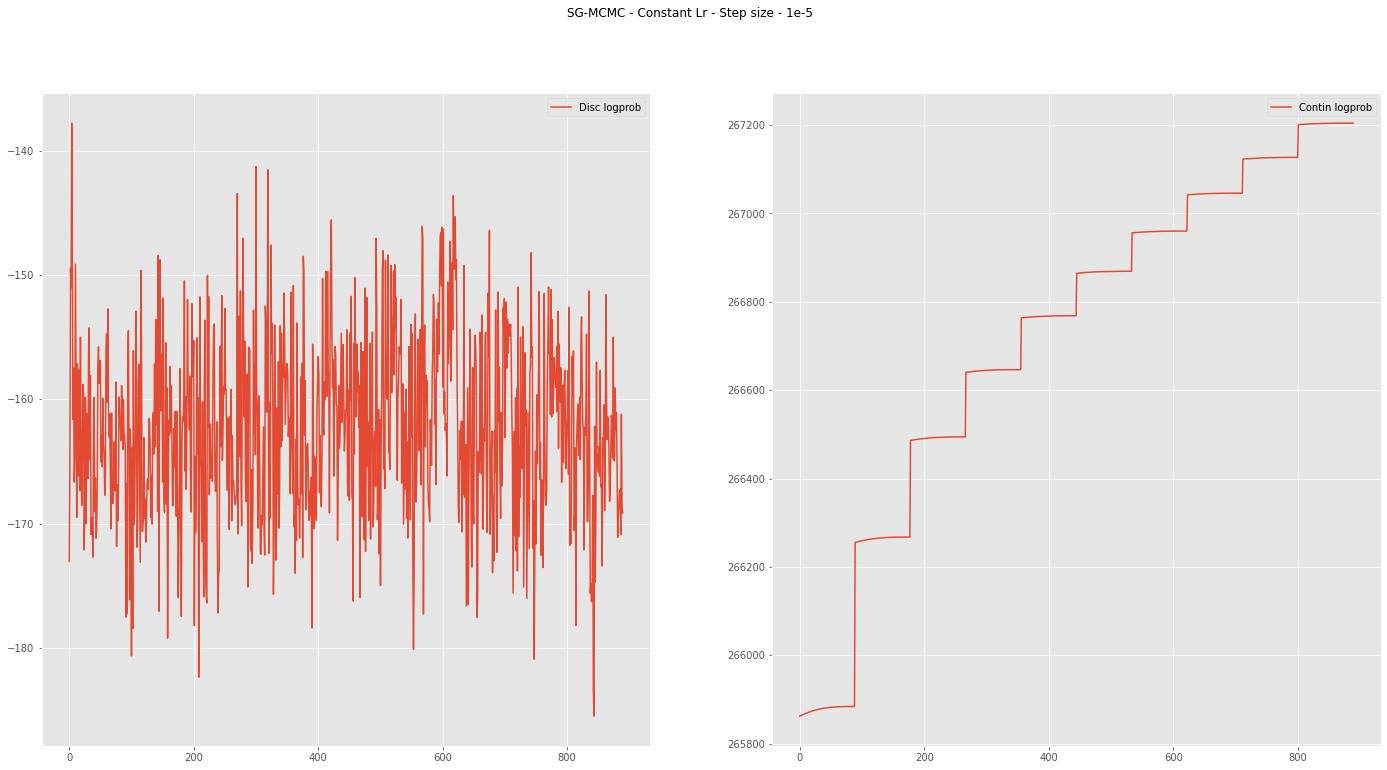

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
fig.suptitle("SG-MCMC - Constant Lr - Step size - 1e-5")

ax1.plot(disc_log_probs, label="Disc logprob")
ax2.plot(contin_log_probs, label="Contin logprob")
# ax2[0].plot(log_lls, label=f"log LL")

ax1.legend()
ax2.legend()
# ax2[0].legend()

In [121]:
tfp.mcmc.effective_sample_size(sgmcmc.states_.discrete_position[None,...])

DeviceArray([[nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             ...,
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan],
             [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [120]:
sgmcmc.states_.discrete_position[None,...].shape

(1, 890, 500)